In [9]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt

parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from src.pricing import (
    black_scholes_call, black_scholes_put,
    mc_european_call, mc_european_put
)

figures_dir = os.path.join(parent_dir, "figures")
os.makedirs(figures_dir, exist_ok=True)


In [11]:
from src.utils import MCResult
import inspect

print(MCResult)
print(MCResult.__annotations__)

<class 'src.utils.MCResult'>
{'price': 'float', 'variance': 'float', 'stderr': 'float', 'ci': 'tuple[float, float]', 'n_paths': 'int', 'confidence': 'float', 'runtime': 'float | None'}


In [53]:
S0 = 100.0
K = 105.0
T = 1.0
r = 0.02
sigma = 0.25
n_steps = 252
n_paths = 100_000
seed = 123

bs_call = black_scholes_call(S0, K, T, r, sigma)
bs_put  = black_scholes_put(S0, K, T, r, sigma)

mc_call = mc_european_call(S0, K, T, r, sigma, n_steps, n_paths, seed=seed, return_details=True)
mc_put  = mc_european_put (S0, K, T, r, sigma, n_steps, n_paths, seed=seed, return_details=True)

print("Black–Scholes Call:", bs_call)
print("MC Call:", mc_call)
print()
print("Black–Scholes Put :", bs_put)
print("MC Put:", mc_put)


Black–Scholes Call: 19.749186302904306
MC Call: MCResult(price=19.798052145324302, variance=1587.6333318327706, stderr=0.1260013226848342, ci=(19.551094090857617, 20.045010199790987), n_paths=100000, confidence=0.95, runtime=0.003526817999954801)

Black–Scholes Put : 19.72945098019334
MC Put: MCResult(price=19.71162567669595, variance=479.3016766353261, stderr=0.06923161681163643, ci=(19.575934201153665, 19.847317152238233), n_paths=100000, confidence=0.95, runtime=0.002715880000323523)


In [55]:
n_paths_grid = [1_000, 5_000, 10_000, 50_000, 100_000, 200_000]
prices = []
ci_lows = []
ci_highs = []
runtimes = []
abs_err = []
stderrs = []

bs = bs_call

for n in n_paths_grid:
    res = mc_european_call(S0, K, T, r, sigma, n_steps, n, seed=seed, return_details=True)
    prices.append(res.price)
    ci_lows.append(res.ci[0])
    ci_highs.append(res.ci[1])
    runtimes.append(res.runtime)
    abs_err.append(abs(res.price - bs))
    stderrs.append(res.stderr)
    
prices = np.array(prices)
ci_lows = np.array(ci_lows)
ci_highs = np.array(ci_highs)
runtimes = np.array(runtimes)
abs_err = np.array(abs_err)
stderrs = np.array(stderrs)
ci_half_width = 1.959963984540054 * stderrs

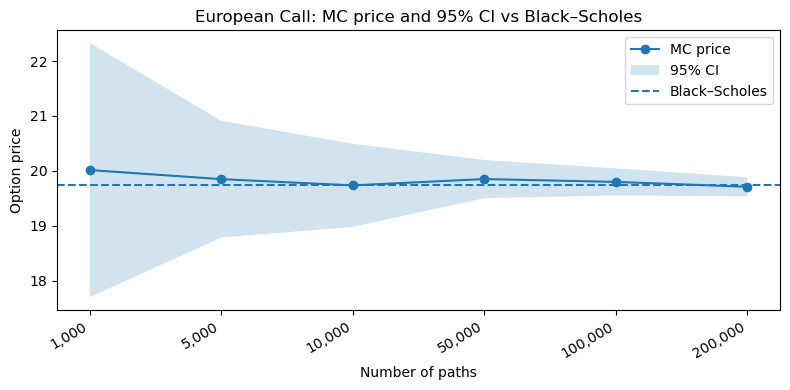

In [57]:
plt.figure(figsize=(8, 4))
x = np.arange(len(n_paths_grid))
plt.plot(x, prices, marker="o", label="MC price")
plt.fill_between(x, ci_lows, ci_highs, alpha=0.2, label="95% CI")
plt.axhline(bs, linestyle="--", label="Black–Scholes")

plt.xticks(x, [f"{n:,}" for n in n_paths_grid], rotation=30, ha="right")
plt.xlabel("Number of paths")
plt.ylabel("Option price")
plt.title("European Call: MC price and 95% CI vs Black–Scholes")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "phase3_call_price_ci_convergence.png"), dpi=150)
plt.show()


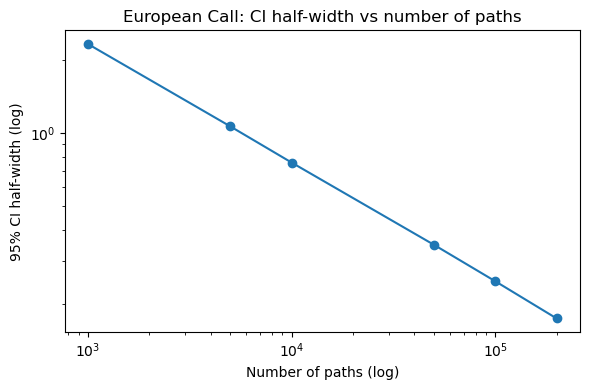

In [59]:
plt.figure(figsize=(6, 4))
plt.loglog(n_paths_grid, ci_half_width, marker="o")
plt.xlabel("Number of paths (log)")
plt.ylabel("95% CI half-width (log)")
plt.title("European Call: CI half-width vs number of paths")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "phase3_call_ci_half_width_loglog.png"), dpi=150)
plt.show()


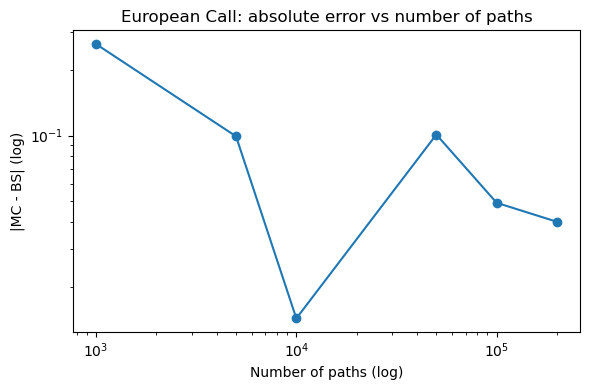

In [61]:
plt.figure(figsize=(6, 4))
plt.loglog(n_paths_grid, abs_err, marker="o")
plt.xlabel("Number of paths (log)")
plt.ylabel("|MC - BS| (log)")
plt.title("European Call: absolute error vs number of paths")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "phase3_call_abs_error_loglog.png"), dpi=150)
plt.show()


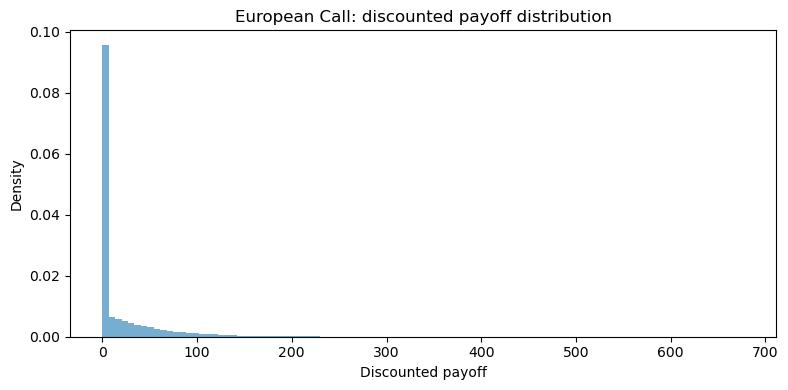

In [63]:
# Use one MC run and visualize discounted payoff distribution
res = mc_european_call(S0, K, T, r, sigma, n_steps, 200_000, seed=seed, return_details=True)

# To get the discounted payoffs, re-run with same seed and recompute quickly here:
from src.gbm import simulate_gbm_paths
from src.options import payoff_call

_, paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, 200_000, seed=seed)
S_T = paths[:, -1]
disc_payoffs = np.exp(-r*T) * payoff_call(S_T, K)

plt.figure(figsize=(8, 4))
plt.hist(disc_payoffs, bins=100, density=True, alpha=0.6)
plt.xlabel("Discounted payoff")
plt.ylabel("Density")
plt.title("European Call: discounted payoff distribution")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "phase3_call_discounted_payoffs_hist.png"), dpi=150)
plt.show()


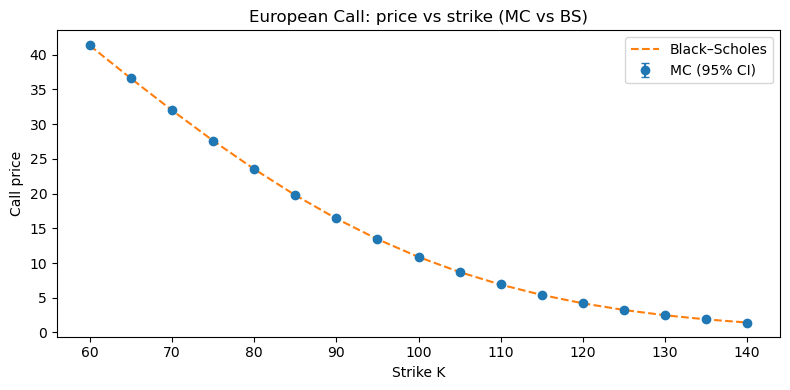

In [38]:
Ks = np.linspace(60, 140, 17)
mc_prices = []
mc_errbars = []
bs_prices = []

n_paths_sweep = 100_000
seed = 123

for K_i in Ks:
    res = mc_european_call(S0, float(K_i), T, r, sigma, n_steps, n_paths_sweep, seed=seed, return_details=True)
    mc_prices.append(res.price)
    mc_errbars.append(1.959963984540054 * res.stderr)  # 95% half-width
    bs_prices.append(black_scholes_call(S0, float(K_i), T, r, sigma))

mc_prices = np.array(mc_prices)
mc_errbars = np.array(mc_errbars)
bs_prices = np.array(bs_prices)

plt.figure(figsize=(8, 4))
plt.errorbar(Ks, mc_prices, yerr=mc_errbars, fmt="o", capsize=3, label="MC (95% CI)")
plt.plot(Ks, bs_prices, linestyle="--", label="Black–Scholes")
plt.xlabel("Strike K")
plt.ylabel("Call price")
plt.title("European Call: price vs strike (MC vs BS)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "phase3_call_price_vs_strike.png"), dpi=150)
plt.show()
